# Train R-Net with all the boxes
In this notebook R-Net is trained with all the valid boxes output by P-Net. Every epoch the dataloader feeds different boxes into R-Net with every box having equal probability to be chosen.<br>

- **1116329** train boxes, **269648** eval boxes
- EPOCH = 40
- LR = 0.001 + reduce by a factor of 0.1 against a patience of 5 epoch
- batch size = 32
- num of worker = 8
- loss configuration: 1.0 for label, 0.5 for offset

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

## customized dataset

**1. read txt file generated by notebook *Make_ONet_data.ipynb***

txt format:<br>

`image path`||`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`|`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`......\n<br>
`image path`||`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`|`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`......\n<br>
......<br><br>

**2. data loading**<br>
There are **1116329** predicted boxes in 12851 images for training and **269648** boxes in 3220 images for evaluation. To make full use of the data, this customized dataset is designed to store all the boxes in lists and only a random part of the whole dataset will be used in each epoch. This way of loading data largely prevent overfitting and reduce the time for training.<br> <br>
**Tip:** To make sure that no box will be re-used in the same trial of training, a good technique is to pop the box, which is used in the latter notebooks.

In [2]:
root =  '/kaggle/input/wider-data'
setdic = {'train':(1116328,'WIDER/WIDER_train'), # 1116329 boxes and 12851 images in total
           'eval':(269647,'WIDER/WIDER_val')}    # 269648 boxes and 3220 images in total


class RnetDataset(data.Dataset):
    def __init__(self, phase, epoch_size, Random=True, face_landmark=None):
        
        self.length = epoch_size
        self.index_end = setdic[phase][0]
        self.images = []
        self.offsets = []
        self.labels = []
        self.boxes = []

        file = open('/kaggle/input/-mytxt/rnet_'+ phase +'.txt')    
        lines = file.readlines()

        for line in lines:

            line = line.strip()
            idx = line.find('||')
            img_path = line[:idx]
            if (not self.is_valid_image(img_path)) or (idx==-1):
                continue
            faces = line[idx+2:].split('|')  # faces = labels + boxes

            for face in faces:
                [label, true_box, box] = face.split('+')

                true_box=[int(i) for i in true_box.split()]
                box=[int(i) for i in box.split()]
                offset = self.cal_offset(true_box,box)
                label = [1.0 if label in ['p', 'pf', 'l'] else 0.0]

                self.images.append(img_path)
                self.boxes.append(box)
                self.offsets.append(offset)
                self.labels.append(label)
        
        
    def cal_offset(self,face, box):
        offset = [
            (face[0] - box[0]) / float(box[2] - box[0]),
            (face[1] - box[1]) / float(box[3] - box[1]),
            (face[2] - box[2]) / float(box[2] - box[0]),
            (face[3] - box[3]) / float(box[3] - box[1]),
        ]
        return offset
    
    
    def is_valid_image(self,path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid


    def __getitem__(self, index):
        
        index = random.randint(0,self.index_end)
        
        image = Image.open(self.images[index])
        box = self.boxes[index]
        crop_img = tf.resized_crop(image, box[1], box[0], box[3]-box[1]+1, box[2]-box[0]+1, (24,24), interpolation=2)
        crop_img = tf.to_tensor(crop_img)
        label = torch.FloatTensor(self.labels[index])
        offset = torch.FloatTensor(self.offsets[index])
        landmark = torch.FloatTensor(10 * [0.0])
        landmark_flag = torch.FloatTensor([0.0])
        
        return (crop_img, label, offset, landmark_flag, landmark)

    
    def __len__(self):
        return self.length

## R-Net

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(28, 48, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 64, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv4 = nn.Linear(64 * 2 * 2, 128)
        self.prelu4 = nn.PReLU()
        self.conv5_1 = nn.Linear(128, 1)
        self.conv5_2 = nn.Linear(128, 4)
        self.conv5_3 = nn.Linear(128, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark

## customized  loss function
linear combination of **class loss**, **offset loss** and **lamdmark loss** (not used)

In [4]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):

        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()



    def cls_loss(self, gt_label, pred_label):

        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    

    def box_loss(self, gt_label, gt_offset, pred_offset):

        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        mask = torch.eq(gt_label, 1)

        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        valid_sample_num = valid_gt_offset.shape[0]
        if 0 == valid_sample_num:

            return torch.tensor([0.0])
        else:
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor


    def landmark_loss(self, landmark_flag, gt_landmark=None, pred_landmark=None):
        
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(landmark_flag)
        mask = torch.eq(gt_label, 1)
        valid_gt_landmark = gt_landmark[mask, :]
        valid_pred_landmark = pred_landmark[mask, :]
        valid_sample_num = valid_gt_landmark.shape[0]
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_landmark(valid_pred_landmark, valid_gt_landmark) * self.land_factor

        
    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset) \
               + self.landmark_loss(landmark_flag, gt_landmark, pred_landmark)

In [5]:
def IoU(box, boxes):
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [6]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

In [7]:
def train_Rnet(model, criterion, optimizer, loss_config, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':([],[]), 'eval':([],[])} # 'train':([loss],[acc])
    iter_count = 0
    

    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for (img_tensor, label, offset, landmark_flag, landmark) in R_trainLoader:
            
            iter_count += 1
            iter_begin = time.time()
            
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            det, box, ldmk = model(img_tensor)
            if landmark==None:
                ldmk=None
            optimizer.zero_grad()
            all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
            
            iter_length = time.time() - iter_begin

            all_loss.backward()
            optimizer.step()
            
            running_loss += all_loss.item() * img_tensor.size(0)
            
        epoch_loss = running_loss / R_trainSize
        statistics['train'][0].append(epoch_loss)
        if scheduler is not None:
            scheduler.step(epoch_loss)
            lr = optimizer.param_groups[0]['lr']
        print('Train Loss: {:.4f} Acc: NA lr: {:.4f}'.format(epoch_loss,lr))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0

            for (img_tensor, label, offset, landmark_flag, landmark) in R_evalLoader:

                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = model(img_tensor)
                if landmark==None:
                    ldmk=None
                all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)

                running_loss += all_loss.item() * img_tensor.size(0)

            epoch_loss = running_loss / R_evalSize
            statistics['eval'][0].append(epoch_loss)
            print('Eval Loss: {:.4f} Acc: NA'.format(epoch_loss))
        print()
        
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    best_model = copy.deepcopy(model)
    best_model.load_state_dict(best_model_wts)
    
    return best_model, model, statistics

## assign parameters and start training
Here, the coefficient of class loss is set to 1. One can increase this coefficient to emphasize the correctness of class prediction.

In [8]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

LR = 0.001
EPOCH = 40
BATCH_SIZE = 32
NUM_WORKS = 8
Rnet_loss_config = [1.0, 0.5, 0.5]


R_trainset = RnetDataset('train',5000)
R_trainLoader = DataLoader(R_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

R_evalset = RnetDataset('eval',500)
R_evalLoader = DataLoader(R_evalset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

R_trainSize = len(R_trainset)
R_evalSize = len(R_evalset)
print(R_trainSize)
print(R_evalSize)

model = R_Net().cuda()

for param in model.conv5_3.parameters():
    param.requires_grad = False
    
optimizer = opt.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = LossFn(cls_factor=Rnet_loss_config[0], box_factor=Rnet_loss_config[1], landmark_factor=Rnet_loss_config[2])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, cooldown=2, min_lr=1e-08)

5000
500


In [9]:
model, final_model, statistics = train_Rnet(model, criterion, optimizer, Rnet_loss_config, scheduler)

Epoch 0/39
----------
Train Loss: 0.3771 Acc: NA lr: 0.0010
Eval Loss: 0.3628 Acc: NA

Epoch 1/39
----------
Train Loss: 0.3586 Acc: NA lr: 0.0010
Eval Loss: 0.3518 Acc: NA

Epoch 2/39
----------
Train Loss: 0.3196 Acc: NA lr: 0.0010
Eval Loss: 0.3055 Acc: NA

Epoch 3/39
----------
Train Loss: 0.3319 Acc: NA lr: 0.0010
Eval Loss: 0.3446 Acc: NA

Epoch 4/39
----------
Train Loss: 0.3110 Acc: NA lr: 0.0010
Eval Loss: 0.2732 Acc: NA

Epoch 5/39
----------
Train Loss: 0.3226 Acc: NA lr: 0.0010
Eval Loss: 0.2791 Acc: NA

Epoch 6/39
----------
Train Loss: 0.2850 Acc: NA lr: 0.0010
Eval Loss: 0.2561 Acc: NA

Epoch 7/39
----------
Train Loss: 0.2616 Acc: NA lr: 0.0010
Eval Loss: 0.3478 Acc: NA

Epoch 8/39
----------
Train Loss: 0.2602 Acc: NA lr: 0.0010
Eval Loss: 0.2666 Acc: NA

Epoch 9/39
----------
Train Loss: 0.2505 Acc: NA lr: 0.0010
Eval Loss: 0.2222 Acc: NA

Epoch 10/39
----------
Train Loss: 0.2549 Acc: NA lr: 0.0010
Eval Loss: 0.2706 Acc: NA

Epoch 11/39
----------
Train Loss: 0.2316 

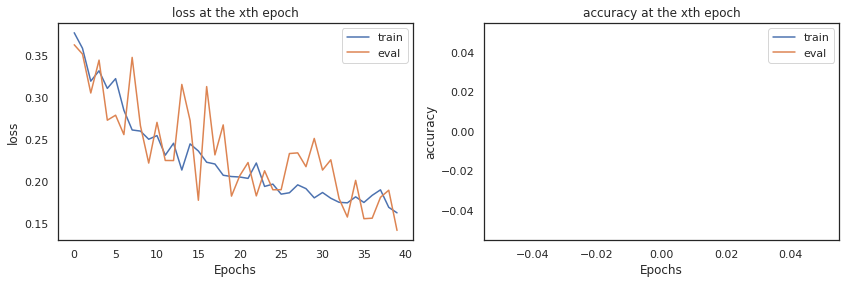

In [10]:
name = 'RNet4'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name)